In [1]:
!pip install seaborn

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib Inline
import seaborn as sns

2024-04-10 23:56:51.968900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('animes.csv',usecols=['synopsis', 'genre'])

df.head()

,synopsis,genre
0,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun..."
1,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun..."
2,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F..."
3,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ..."
4,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   synopsis  18336 non-null  object
 1   genre     19311 non-null  object
dtypes: object(2)
memory usage: 301.9+ KB


In [5]:
df.dropna(subset = ['synopsis'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18336 entries, 0 to 19310
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   synopsis  18336 non-null  object
 1   genre     18336 non-null  object
dtypes: object(2)
memory usage: 429.8+ KB


In [7]:
#imprinting pprint for pretty printing
from pprint import pprint
#importing defaultdict
from collections import defaultdict
#saving total genres here.
hash_map = defaultdict(lambda: 0)
#saving each row's genre in genrelist
genrelist = []
for text in df['genre']:
    templist = text[2:len(text)-2].split("', '")
    for i in range(len(templist)):
        if templist[i] == '':
            templist.pop(i)
            break
    genrelist.append(templist)
    for j in templist:
        hash_map[j] += 1
        
# Adding genrelist Column
df['genrelist'] = genrelist

pprint(len(hash_map))
pprint(hash_map)

43
defaultdict(<function <lambda> at 0x7f8d60c43910>,
            {'Action': 4034,
             'Adventure': 3036,
             'Cars': 128,
             'Comedy': 6186,
             'Dementia': 405,
             'Demons': 577,
             'Drama': 2933,
             'Ecchi': 784,
             'Fantasy': 3259,
             'Game': 380,
             'Harem': 423,
             'Hentai': 2328,
             'Historical': 1164,
             'Horror': 505,
             'Josei': 115,
             'Kids': 2354,
             'Magic': 1126,
             'Martial Arts': 397,
             'Mecha': 1146,
             'Military': 651,
             'Music': 1945,
             'Mystery': 849,
             'Parody': 680,
             'Police': 296,
             'Psychological': 412,
             'Romance': 2121,
             'Samurai': 230,
             'School': 1853,
             'Sci-Fi': 2731,
             'Seinen': 963,
             'Shoujo': 774,
             'Shoujo Ai': 84,
             'Shoun

<Axes: >

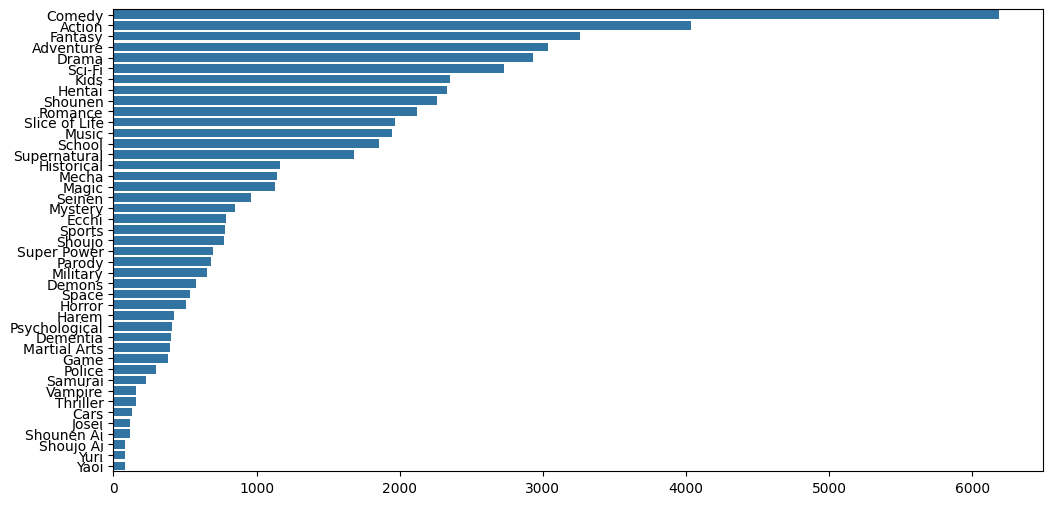

In [8]:

temp = list(hash_map.items())
temp.sort(key=lambda x: x[1], reverse=True)
plt.rcParams['figure.figsize'] = (12, 6)
y,x = [temp[i][0] for i in range(len(temp))], [temp[i][1] for i in range(len(temp))]
sns.barplot(x=x, y=y)

In [9]:
df.drop(columns=['genre'], inplace=True)

In [10]:
df

,synopsis,genrelist
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]"
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]"
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]"
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M..."
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]"
...,...,...
19306,Cocona is an average middle schooler living wi...,"[Sci-Fi, Adventure, Comedy, Magic]"
19307,"While visiting the National Library, junior-hi...","[Adventure, Fantasy, Magic, Martial Arts, Come..."
19308,"Years ago, all of the ghosts in a haunted scho...","[Mystery, Horror, Supernatural]"
19309,Inuyasha and company have finally destroyed Na...,"[Action, Adventure, Comedy, Historical, Demons..."


In [11]:
import re

# Function for cleaning the text
def clean_text(text):
    text = re.sub('\'', "", text)
    text = re.sub('[^a-zA-Z]', " ", text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [12]:
df.loc[:, 'cleaned_syn'] = df.loc[:,'synopsis'].apply(clean_text)
df

,synopsis,genrelist,cleaned_syn
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",following their participation at the inter hig...
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",music accompanies the path of the human metron...
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",the abyss a gaping chasm stretching down into ...
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",in order for something to be obtained somethin...
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",after helping revive the legendary vampire kis...
...,...,...,...
19306,Cocona is an average middle schooler living wi...,"[Sci-Fi, Adventure, Comedy, Magic]",cocona is an average middle schooler living wi...
19307,"While visiting the National Library, junior-hi...","[Adventure, Fantasy, Magic, Martial Arts, Come...",while visiting the national library junior hig...
19308,"Years ago, all of the ghosts in a haunted scho...","[Mystery, Horror, Supernatural]",years ago all of the ghosts in a haunted schoo...
19309,Inuyasha and company have finally destroyed Na...,"[Action, Adventure, Comedy, Historical, Demons...",inuyasha and company have finally destroyed na...


In [13]:
#importing nltk libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/klek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
### Python Script to remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('source')
words = defaultdict(lambda: 0)
def rem_stop(text):
    for i in text.split():
        new_text = []
        if i not in stop_words:
            new_text.append(i)
            words[i] += 1
    new_text = [i for i in text.split() if not i in stop_words]
    return ' '.join(new_text)

df.loc[:, 'cleaned_syn'] = df.loc[:, 'cleaned_syn'].apply(rem_stop)
df

,synopsis,genrelist,cleaned_syn
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",following participation inter high karasuno hi...
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",music accompanies path human metronome prodigi...
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",abyss gaping chasm stretching depths earth fil...
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",order something obtained something equal value...
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",helping revive legendary vampire kiss shot ace...
...,...,...,...
19306,Cocona is an average middle schooler living wi...,"[Sci-Fi, Adventure, Comedy, Magic]",cocona average middle schooler living grandmot...
19307,"While visiting the National Library, junior-hi...","[Adventure, Fantasy, Magic, Martial Arts, Come...",visiting national library junior high students...
19308,"Years ago, all of the ghosts in a haunted scho...","[Mystery, Horror, Supernatural]",years ago ghosts haunted schoolhouse banished ...
19309,Inuyasha and company have finally destroyed Na...,"[Action, Adventure, Comedy, Historical, Demons...",inuyasha company finally destroyed naraku star...


In [15]:
tmp = sorted(words, key = lambda x: words[x], reverse = True)

In [16]:
#total words
values = []
for i in tmp:
    values.append(words[i])
print(sum(values))

730171


<Axes: >

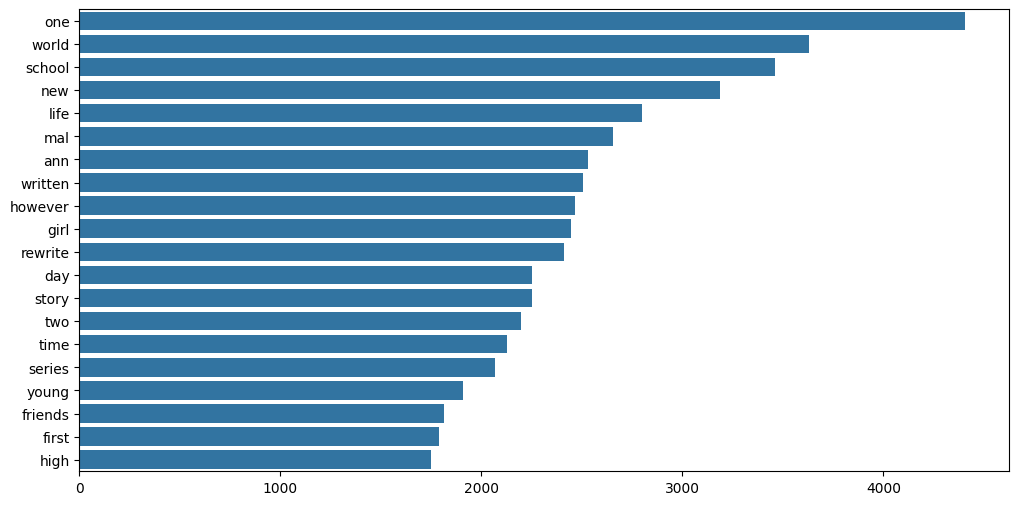

In [17]:
sns.barplot(x=values[:20], y=tmp[:20])

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for _ in range(5):
    # Assuming df['genrelist'] contains the multi-label genre information
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genrelist'])
    y = multilabel_binarizer.transform(df['genrelist'])

    # Split the data into training and testing sets
    xtrain, xtest, ytrain, ytest = train_test_split(df['cleaned_syn'], y, test_size=0.2)

    # Initialize and fit the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xtest_tfidf = tfidf_vectorizer.transform(xtest)

    # Initialize and train the Logistic Regression classifier
    model = LogisticRegression()
    classif = OneVsRestClassifier(model)
    classif.fit(xtrain_tfidf, ytrain)

    # Predict on the test set
    y_pred = classif.predict(xtest_tfidf)
    y_pred_prob = classif.predict_proba(xtest_tfidf)
    y_pred_new = (y_pred_prob >= 0.20).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred_new, average='micro')
    recall = recall_score(ytest, y_pred_new, average='micro')
    f1 = f1_score(ytest, y_pred_new, average='micro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")


Accuracy: 0.1469
Precision: 0.5449
Recall: 0.6208
F1 Score: 0.5804

Accuracy: 0.1388
Precision: 0.5383
Recall: 0.6266
F1 Score: 0.5791

Accuracy: 0.1464
Precision: 0.5366
Recall: 0.6188
F1 Score: 0.5748

Accuracy: 0.1379
Precision: 0.5330
Recall: 0.6171
F1 Score: 0.5720

Accuracy: 0.1339
Precision: 0.5343
Recall: 0.6167
F1 Score: 0.5726

